# Recreating " Melanoma diagnosis using deep learning techniques on dermatoscopic images"

## Imports and Data Processing

### Imports

In [ ]:
import torch
import torch.nn as nn
import os
from torch.utils.data import  DataLoader
from dataloader import ISICClassImageDataset
from transforms import dataTransforms
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
device = torch.device(device)

from torchvision.models import ResNet152_Weights
from torchvision.models import resnet152
weights = ResNet152_Weights.DEFAULT

Using cuda device


### Data Processing

In [ ]:
#constants:
batch_size = 64
data_aug_type = "1" #what data augmentation schema to train on
#Dataset to train on
dataset = "Dataset_2017"
#Dataset to test on:
test_dataset = "Dataset_2017"
#Enforce the specific requirements for each model
if data_aug_type == "5":
    dataset = dataset+"_ph2"
    test_dataset = test_dataset+"_ph2"
    data_aug_type_temp = data_aug_type
elif data_aug_type == "6":
    data_aug_type_temp = "2"
elif data_aug_type == "7":
    data_aug_type_temp = "1"
else:
    data_aug_type_temp = data_aug_type

size=(224,224)
transforms = dataTransforms(data_aug_type,size=size,mask=False)


Train_Dataset      = ISICClassImageDataset(dataset,"Training",data_aug_type=data_aug_type_temp,size=size,bb_data_type=data_aug_type_temp)#, target_transform=Lambda(lambda y: torch.zeros( 2, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y,dtype=torch.int64), value=1)),size=size)
Validation_Dataset = ISICClassImageDataset(dataset,"Validation",data_aug_type="1", size=size,bb_data_type=data_aug_type_temp)
Test_Dataset       = ISICClassImageDataset(test_dataset,"Test",data_aug_type="1", size=size,bb_data_type=data_aug_type_temp)

data_loader_params = {
    'batch_size': batch_size,  # Batch size for data loading
    'num_workers': 10,  # Number of subprocesses to use for data loading
    'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': True,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': 'cuda' ,  # Specifies the device where the data should be loaded.
}
train_dataloader      = DataLoader(Train_Dataset, **data_loader_params, shuffle=True)
validation_dataloader = DataLoader(Validation_Dataset, **data_loader_params, shuffle=True)
test_dataloader       = DataLoader(Test_Dataset, **data_loader_params, shuffle=False,in_order=True)
#print(len(train_dataloader))

### Training function

In [3]:
REPORT_FREQUENCY = 10
def train_one_epoch(model, training_loader, epoch_index, loss_fn, tb_writer, optimizer, lr_scheduler, scaler= None):
    """
    This function will train your model and save the one that perfroms the best of validation data  
    model: the model you wish to test  
    train_loader: the data loader of the training dataset  
    epoch_index: what epoch we are in for reporting purposes  
    loss_fn: your chose loss function  
    tb_writer: a summaryWriter used for tracking our training  
    optimizer: the algorthim to step toward the optimal solution  
    lr_scheduler: the lr_scheduler changes the lr dynamically as needed  
    scaler: scales the loss dues to our use of mixed precision  
    """
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, targets = data
        #send them to the model's device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        #use automatic mixed precision to reduce memory consumption and allow us to run on more limited resources
        with torch.amp.autocast(torch.device(device).type):
            # Make predictions for this batch
            outputs = model(inputs)
            # Compute the loss and its gradients
            loss = loss_fn(outputs, targets)
        running_loss += loss
        if scaler:#if were scaling our loss
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            old_scaler = scaler.get_scale()
            scaler.update()
            new_scaler = scaler.get_scale()
            if new_scaler >= old_scaler:
                lr_scheduler.step()
        else:
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        # Gather data and report
        
        if i % REPORT_FREQUENCY == REPORT_FREQUENCY-1:
            last_loss = running_loss / i # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
    return last_loss

## ResNet initialization

In [ ]:
ResNet_model_train = False
fine_tune = False
loss_weight = 0.5

#Enforce naming conventions:
if dataset == "Dataset_2018":
    ResNet_model_name = 'ResNet152_{}_{}'.format(7,loss_weight)
else:
    ResNet_model_name = 'ResNet152_{}_{}'.format(data_aug_type,loss_weight)
ResNet_model_path = os.path.join('Trained_Models',ResNet_model_name)
lr = 0.0001
EPOCHS = 100
#Model and optimizers:
ResNet_model = resnet152(weights=weights, progress=False)
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([1-loss_weight,loss_weight],device=device))
ResNet_model.fc = nn.Linear(in_features=2048,out_features=2,bias=True)#change our number of classes to 2
optimizer = torch.optim.SGD(ResNet_model.parameters(), lr=lr,weight_decay=0.000001)
scaler = torch.amp.GradScaler("cuda")
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=EPOCHS*len(train_dataloader))
print(ResNet_model_path)
#print(ResNet_model)

Trained_Models\ResNet152_1_0.5


In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
if fine_tune:
    checkpoint = torch.load(ResNet_model_path)
    ResNet_model.load_state_dict(checkpoint)
    #change the path of the best model to be model 6 to bring it in line with the paper
    ResNet_model_path = 'Trained_Models\\ResNet152_Best_{}_{}'.format(6,loss_weight)
if ResNet_model_train:
    ResNet_model.to(device)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/ResNet{}'.format(timestamp))
    epoch_number = 0

    best_vloss = 1_000_000.

    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        ResNet_model.train(True)
        avg_loss = train_one_epoch(ResNet_model, train_dataloader, epoch_number, loss_fn, writer,optimizer,lr_scheduler,scaler)

        running_vloss = 0.0
        best_acc = 0.0
        num_correct = 0
        num_samples = 0
        true_malig = 0.0
        true_benign = 0.0
        total_malig = 0.00000001 #prevent divide by zero
        total_benign = 0.0          
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        ResNet_model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validation_dataloader):
                vinputs, vtargets = vdata
                vinputs = vinputs.to(device)
                vtargets = vtargets.to(device)
                
                #again were using AMP to allow us to train faster
                with torch.amp.autocast(torch.device(device).type):
                    voutputs = ResNet_model(vinputs)
                    vloss = loss_fn(voutputs,vtargets)
                    running_vloss += vloss
                    _, preds = voutputs.max(1)
                    _, vtarget = vtargets.max(1)
                num_correct += (preds == vtarget).sum()
                num_samples += preds.size(0)
                true_malig   += torch.sum(((preds == 1.0) & (vtarget == 1.0))).item()
                true_benign  += torch.sum(((preds == 0.0) & (vtarget == 0.0))).item()
                total_malig  += torch.sum(preds == 1.0).item()
                total_benign += torch.sum(preds == 0.0).item()
                
                
        acc = float(num_correct) / num_samples
        bal_acc = 0.5*((true_malig/total_malig)+(true_benign/total_benign))
        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
        print('Accuracy:', acc, "Balanced Accuracy:", bal_acc)
        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.add_scalar("Balanced Accuracy",bal_acc,epoch_number+1)
        writer.flush()

        # Track best performance, and save the model's state
        #AKA early stopping, a form of regularization we talked about it class
        if bal_acc > best_acc:
            best_acc = bal_acc
            torch.save(ResNet_model.state_dict(), "{}".format(ResNet_model_path))

        epoch_number += 1


Here we can load our lowest loss model that we trained:

In [ ]:
if not ResNet_model_train:
    checkpoint = torch.load(ResNet_model_path)
    ResNet_model.load_state_dict(checkpoint)
    ResNet_model.to(device)

### Testing our Model

In [7]:
ResNet_model.eval()
running_loss = 0.0
best_acc = 0.0
num_correct = 0.0
num_samples = 0.0
true_malig = 0.0
true_benign = 0.0
false_malig = 0.0
false_benign = 0.0
total_malig = 0.0
total_benign = 0.0
# Disable gradient computation and reduce memory consumption.
with torch.no_grad():
    for i, vdata in enumerate(test_dataloader):
        inputs, targets = vdata
        inputs = inputs.to(device)
        targets = targets.to(device)
        #again were using AMP to allow us to train faster
        outputs = ResNet_model(inputs)
        loss = loss_fn(outputs,targets)
        running_loss += loss
        _, preds = outputs.max(1)
        _, target = targets.max(1)
        num_correct += torch.sum(preds == target).item()
        num_samples += preds.size(0)
        #print(((preds == 0.0) == (target == 0.0)) == 0.0)
        true_malig   += torch.sum(((preds == 1.0) & (target == 1.0))).item()
        true_benign  += torch.sum(((preds == 0.0) & (target == 0.0))).item()
        false_malig   += torch.sum(((preds == 1.0) & (target == 0.0))).item()
        false_benign  += torch.sum(((preds == 0.0) & (target == 1.0))).item()
        total_malig  += torch.sum(preds == 1.0).item()
        total_benign += torch.sum(preds == 0.0).item()
    acc = (num_correct / num_samples)
    


## Generating Metrics for evaluation

Accuracy: 0.7691798941798942
Balanced Accuracy: 0.6059498477455333
Precision: 0.2706185567010309
Recall: 0.6140350877192983
F1-Score: 0.3756708407871198
Specificity: 0.7889634601043997


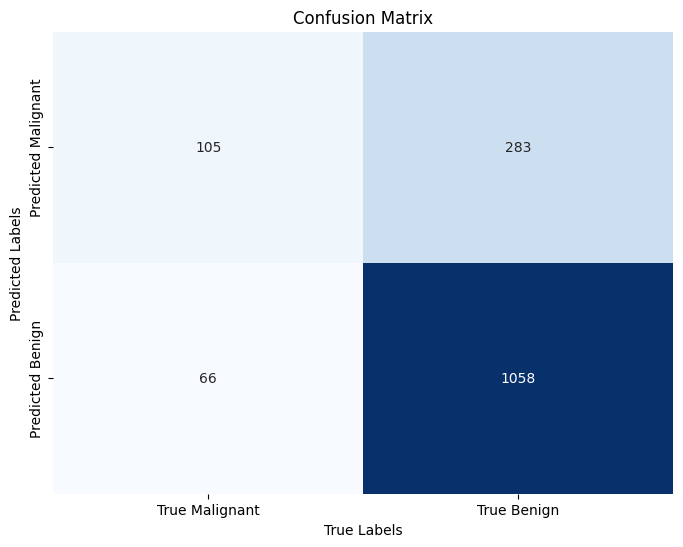

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
bal_acc = 0.5*((true_malig/total_malig)+(true_benign/total_benign))
precision = true_malig/(true_malig+false_malig)
recall = true_malig/(true_malig+false_benign)
f1 = (2*precision*recall)/(precision+recall)
specificity = true_benign/(true_benign+false_malig)
print('Accuracy:', acc)
print('Balanced Accuracy:', bal_acc)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)
print('Specificity:', specificity)

#Print a confustion matrix for this model
confusion_matrix = [[int(true_malig),int(false_malig)],[int(false_benign),int(true_benign)]]
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            yticklabels=['Predicted Malignant', 'Predicted Benign'],
            xticklabels=['True Malignant', 'True Benign'])
plt.ylabel('Predicted Labels')
plt.xlabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig(os.path.join('Results','{}_on_{}.png'.format(ResNet_model_name,test_dataset)), bbox_inches='tight')
plt.show()

#generate a results csv
row = pd.DataFrame({'Model':[ResNet_model_name],'Test Dataset':[test_dataset],'Accuracy':[acc],'Balanced Accuracy':[bal_acc],'Pecision':[precision],'Recall':[recall],'F1':[f1],'Specificity':[specificity]})
metrics = pd.read_csv(os.path.join('Results','classification_metrics.csv'))
metrics = pd.concat((metrics,row),ignore_index=True)
#save results to a csv file
metrics.to_csv(os.path.join('Results','classification_metrics.csv'),index=False)